<a href="https://colab.research.google.com/github/SarthakV7/TF_image_colorizer/blob/main/TF_Image_colorization_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
from tensorflow.keras.layers import Dense, Conv2D, ReLU, BatchNormalization, Softmax, Conv2DTranspose, UpSampling2D, Input, ZeroPadding2D
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import torch.nn.functional as F
from tqdm.notebook import tqdm
from IPython import embed
from skimage import color
import tensorflow as tf
from PIL import Image
import pandas as pd
import numpy as np
import torch
import glob
import cv2
import os

In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
def load_img(img_path):
	out_np = np.asarray(Image.open(img_path))
	if(out_np.ndim==2):
		out_np = np.tile(out_np[:,:,None],3)
	return out_np

def resize_img(img, HW=(256,256), resample=3):
	return np.asarray(Image.fromarray(img).resize((HW[1],HW[0]), resample=resample))

def preprocess_img(img_rgb_orig, HW=(256,256), resize=False):
  img_rgb_rs = cv2.cvtColor(img_rgb_orig, cv2.COLOR_BGR2RGB)
  if resize:
    img_rgb_rs = resize_img(img_rgb_rs, HW=HW, resample=3)
  img_lab_rs = color.rgb2lab(img_rgb_rs)

  img_l = img_lab_rs[:,:,0]
  img_ab = img_lab_rs[:,:,1:]
  a,b = img_l.shape
  shape = (a,b,1)
  input = np.resize(img_l, new_shape=shape)
  shape = (a,b,2)
  output = np.resize(img_ab, new_shape=shape)

  return (input, output)

def postprocess_tens(tens_orig_l, out_ab, mode='bilinear'):

	HW_orig = tens_orig_l.shape[2:]
	HW = out_ab.shape[2:]

	if(HW_orig[0]!=HW[0] or HW_orig[1]!=HW[1]):
		out_ab_orig = F.interpolate(out_ab, size=HW_orig, mode='bilinear')
	else:
		out_ab_orig = out_ab

	out_lab_orig = torch.cat((tens_orig_l, out_ab_orig), dim=1)
	return color.lab2rgb(out_lab_orig.data.cpu().numpy()[0,...].transpose((1,2,0)))

In [26]:
l_cent = 50.
l_norm = 100.
ab_norm = 110.

def normalize_l(in_l):
  return (in_l-l_cent)/l_norm

def unnormalize_l(in_l):
  return in_l*l_norm + l_cent

def normalize_ab(in_ab):
  return in_ab/ab_norm

def unnormalize_ab(in_ab):
  return in_ab*ab_norm

In [27]:
# data collection
def convert_to_256x256(path, frame_gap=12):
    op_img = []
    vidcap = cv2.VideoCapture(path) 
    success,image = vidcap.read()
    count = 0
    while success:
      success,image = vidcap.read()
      img = resize_img(image)
      op_img.append(img)
        
    l_limit, r_limit = int(0.1*(count//frame_gap)), int((count//frame_gap)*0.9)
    op_img = np.array(op_img)[l_limit:r_limit]
    return op_img

### Reading videos, resizing frames to 256x256 and writing to new video

In [28]:
def resize_join_videos():
  folder = [f'./billboard_2021/{i}' for i in os.listdir('./billboard_2021')]
  out = cv2.VideoWriter('video.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 30, (256,256))
  for path in tqdm(folder):
      vid = convert_to_256x256(path, frame_gap=12)
      for img in vid:
          out.write(img)
  out.release()

### Reading the 256x256 video

In [29]:
# data collection
def get_lab(filename, cp=2000):
    vidcap = cv2.VideoCapture(filename)
    success, image = vidcap.read()
    count = 0
    inp_img = []
    out_img = []
    while success:
      if count>1 and count%cp==0:
        print('saved..!')
        inp_img = np.array(inp_img)
        out_img = np.array(out_img)
        np.save(f'{count//cp}_inp.npy', inp_img)
        np.save(f'{count//cp}_out.npy', out_img)
        inp_img, out_img = [], []
      success,image = vidcap.read()
      inp, out = preprocess_img(image)
      inp_img.append(normalize_l(inp))
      out_img.append(normalize_ab(out))
      count+=1

    inp_img = np.array(inp_img)
    out_img = np.array(out_img)

In [30]:
# !cp '/content/drive/MyDrive/tf_image_colorizer_video.mp4' './'

In [31]:
# filename = './tf_image_colorizer_video.mp4'
# get_lab(filename)

In [32]:
# inp_img = np.load('9_inp.npy')
# out_img = np.load('9_out.npy')

In [33]:
def get_model():
  K.clear_session()

  padding = 'same'
  input_layer = Input(shape=(256,256,1), name='input')

  model1 = Conv2D(64, kernel_size=3, strides=(1,1), use_bias=True, padding=padding)(input_layer)
  model1 = ReLU()(model1)
  model1 = Conv2D(64, kernel_size=3, strides=(2,2), use_bias=True, padding=padding)(model1)
  model1 = ReLU()(model1)
  model1 = BatchNormalization()(model1)

  model2 = Conv2D(128, kernel_size=3, strides=(1,1), use_bias=True, padding=padding)(model1)
  model2 = ReLU()(model2)
  model2 = Conv2D(128, kernel_size=3, strides=(2,2), use_bias=True, padding=padding)(model2)
  model2 = ReLU()(model2)
  model2 = BatchNormalization()(model2)

  model3 = Conv2D(256, kernel_size=3, strides=(1,1), use_bias=True, padding=padding)(model2)
  model3 = ReLU()(model3)
  model3 = Conv2D(256, kernel_size=3, strides=(1,1), use_bias=True, padding=padding)(model3)
  model3 = ReLU()(model3)
  model3 = Conv2D(256, kernel_size=3, strides=(2,2), use_bias=True, padding=padding)(model3)
  model3 = ReLU()(model3)
  model3 = BatchNormalization()(model3)

  model4 = Conv2D(512, kernel_size=3, strides=(1,1), use_bias=True, padding=padding)(model3)
  model4 = ReLU()(model4)
  model4 = Conv2D(512, kernel_size=3, strides=(1,1), use_bias=True, padding=padding)(model4)
  model4 = ReLU()(model4)
  model4 = Conv2D(512, kernel_size=3, strides=(1,1), use_bias=True, padding=padding)(model4)
  model4 = ReLU()(model4)
  model4 = BatchNormalization()(model4)

  model5 = Conv2D(512, kernel_size=3, strides=(1,1), use_bias=True, padding=padding, dilation_rate=(2,2))(model4)
  model5 = ReLU()(model5)
  model5 = Conv2D(512, kernel_size=3, strides=(1,1), use_bias=True, padding=padding, dilation_rate=(2,2))(model5)
  model5 = ReLU()(model5)
  model5 = Conv2D(512, kernel_size=3, strides=(1,1), use_bias=True, padding=padding, dilation_rate=(2,2))(model5)
  model5 = ReLU()(model5)
  model5 = BatchNormalization()(model5)

  model6 = Conv2D(512, kernel_size=3, strides=(1,1), use_bias=True, padding=padding, dilation_rate=(2,2))(model5)
  model6 = ReLU()(model6)
  model6 = Conv2D(512, kernel_size=3, strides=(1,1), use_bias=True, padding=padding, dilation_rate=(2,2))(model6)
  model6 = ReLU()(model6)
  model6 = Conv2D(512, kernel_size=3, strides=(1,1), use_bias=True, padding=padding, dilation_rate=(2,2))(model6)
  model6 = ReLU()(model6)
  model6 = BatchNormalization()(model6)

  model7 = Conv2D(512, kernel_size=3, strides=(1,1), use_bias=True, padding=padding)(model6)
  model7 = ReLU()(model7)
  model7 = Conv2D(512, kernel_size=3, strides=(1,1), use_bias=True, padding=padding)(model7)
  model7 = ReLU()(model7)
  model7 = Conv2D(512, kernel_size=3, strides=(1,1), use_bias=True, padding=padding)(model7)
  model7 = ReLU()(model7)
  model7 = BatchNormalization()(model7)

  model8 = Conv2DTranspose(256, kernel_size=4, strides=(2,2), use_bias=True, padding=padding)(model7)
  model8 = ReLU()(model8)
  model8 = Conv2D(256, kernel_size=3, strides=(1,1), use_bias=True, padding=padding)(model8)
  model8 = ReLU()(model8)
  model8 = Conv2D(256, kernel_size=3, strides=(1,1), use_bias=True, padding=padding)(model8)
  model8 = ReLU()(model8)
  
  model_out = Conv2D(313, kernel_size=1, strides=(1,1), use_bias=True, padding=padding)(model8)
  model_out = Softmax()(model_out)
  model_out = Conv2D(2, kernel_size=1, strides=(1,1), use_bias=False, padding=padding, dilation_rate=(1,1))(model_out)

  model_upsampled = UpSampling2D(size=(4,4), interpolation='bilinear')(model_out)

  model = Model(inputs=input_layer, outputs=model_upsampled)

  return model

In [34]:
# model = get_model()
# model.summary()

In [35]:
# from tensorflow.keras.optimizers import Adam
# model.compile(optimizer=Adam(0.001), loss='mse')

In [36]:
# !cp './drive/MyDrive/tf_image_color.h5' './'
model = tf.keras.models.load_model('tf_image_color.h5')

In [37]:
# model.fit(inp_img, out_img, validation_split=0.2 , epochs=20, batch_size=64)
# model.save('tf_image_color.h5')
# !cp 'tf_image_color.h5' './drive/MyDrive/'

### Testing on b/w video

In [38]:
# !pip install youtube-dl
!youtube-dl 'https://www.youtube.com/watch?v=450p7goxZqg'

[youtube] 450p7goxZqg: Downloading webpage
[download] John Legend - All of Me (Official Video)-450p7goxZqg.mkv has already been downloaded and merged


In [42]:
filename = "./John Legend - All of Me (Official Video)-450p7goxZqg.mkv"

In [43]:
def postprocess(filename, model=model):
  vidcap = cv2.VideoCapture(filename) 
  success, image = vidcap.read()
  count = 0
  op_frames = []
  while success:
    count+=1
    success, image = vidcap.read()
    img_l, _ = preprocess_img(image, resize=True)
    img_l_norm = normalize_l(img_l)
    img_ab = model.predict(np.array([img_l_norm]))[0]
    img_ab = unnormalize_ab(img_ab)
    # print(img_l.shape, img_ab.shape)
    img = np.concatenate([img_l, img_ab], axis=-1)
    shape = image.shape[:2]
    shape = (shape[1], shape[0])
    img = cv2.resize(img, shape, interpolation=cv2.INTER_NEAREST)
    img = color.lab2rgb(img)
    op_frames.append(img)
    if count%10==0:
      print(f'{count} frames processed..!')
    if count>50:
      break

  return np.array(op_frames)

In [44]:
op = postprocess(filename, model=model)

10 frames processed..!
20 frames processed..!
30 frames processed..!
40 frames processed..!
50 frames processed..!


In [45]:
size = op.shape[1:3]

In [47]:
op[44]

array([[[0.02777901, 0.        , 0.        ],
        [0.02777901, 0.        , 0.        ],
        [0.02777901, 0.        , 0.        ],
        ...,
        [0.04114675, 0.        , 0.        ],
        [0.04114675, 0.        , 0.        ],
        [0.04114675, 0.        , 0.        ]],

       [[0.02777901, 0.        , 0.        ],
        [0.02777901, 0.        , 0.        ],
        [0.02777901, 0.        , 0.        ],
        ...,
        [0.04114675, 0.        , 0.        ],
        [0.04114675, 0.        , 0.        ],
        [0.04114675, 0.        , 0.        ]],

       [[0.02777901, 0.        , 0.        ],
        [0.02777901, 0.        , 0.        ],
        [0.02777901, 0.        , 0.        ],
        ...,
        [0.04114675, 0.        , 0.        ],
        [0.04114675, 0.        , 0.        ],
        [0.04114675, 0.        , 0.        ]],

       ...,

       [[0.04363207, 0.        , 0.        ],
        [0.04363207, 0.        , 0.        ],
        [0.04363207, 0

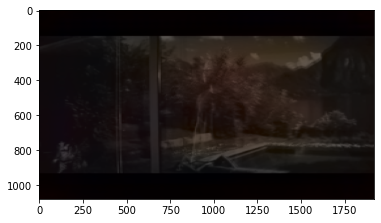

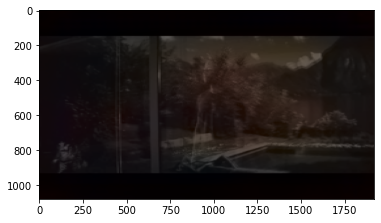

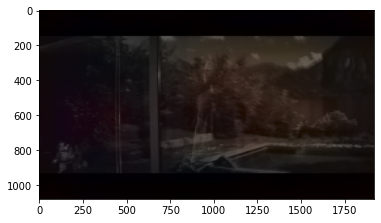

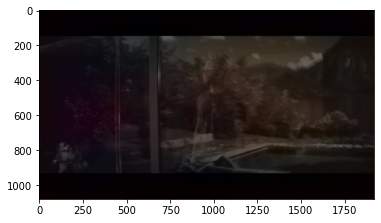

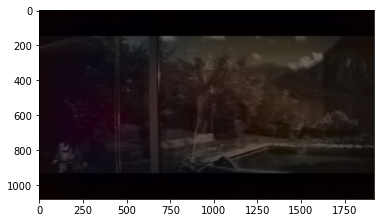

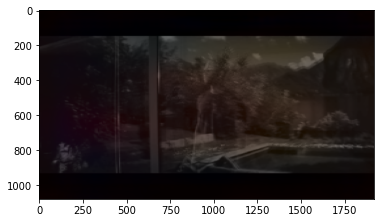

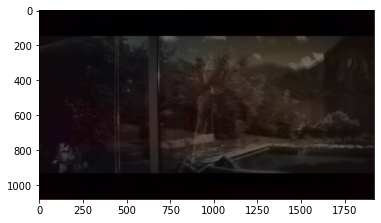

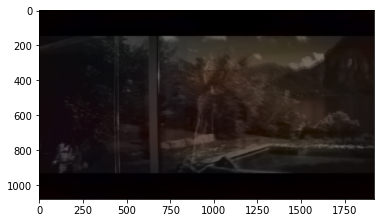

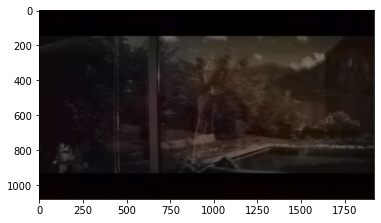

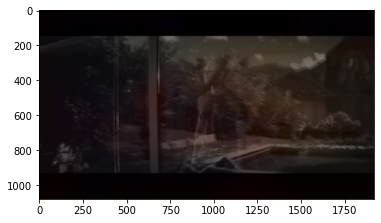

In [48]:
for i in op[-10:]:
  plt.imshow(i)
  plt.show()

In [ ]:
img = cv2.imread('vol_bw.jpg')
inp, out = preprocess_img(img, resize=True)
inp_l = normalize_l(inp_l)
inp_l = np.array([inp])

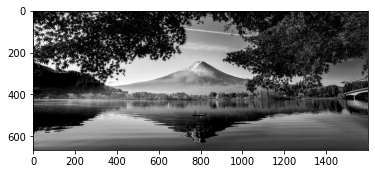

In [ ]:
plt.imshow(img)
plt.show()

In [ ]:
ab = model.predict(inp_l)[0]

In [ ]:
ab = unnormalize_ab(ab)

In [ ]:
ab.shape

(256, 256, 2)

In [ ]:
op = np.concatenate([inp, ab], axis=-1)
op.shape

(256, 256, 3)

In [ ]:
img_rgb = color.lab2rgb(op)
img_rgb.shape

/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 14804 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


(256, 256, 3)

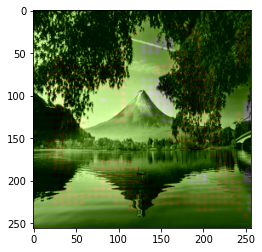

In [ ]:
plt.imshow(img_rgb)
plt.show()